In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random
import time
import shap
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split, StratifiedKFold, cross_val_score,KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.linear_model import Ridge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [3]:
pivot_path = "/content/pivoted_transformed_data.csv"
df = pd.read_csv(pivot_path)

positive_indicators = [
    'CPIA gender equality rating (1=low to 6=high)',
    'Account ownership at a financial institution or with a mobile-money-service provider, poorest 40% (% of population ages 15+)',
    'Access to electricity, rural (% of rural population)',
    'Access to clean fuels and technologies for cooking, rural (% of rural population)',
    'GOAL 2: Zero Hunger (5 year moving average)',
    'Newborns protected against tetanus (%)',
    'School enrollment, primary (% gross)',
    'Life expectancy at birth, total (years)',
    'People using at least basic sanitation services (% of population)'
]

negative_indicators = [
    'Gini index',
    'Maternal mortality ratio (modeled estimate, per 100,000 live births)',
    'Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population)'
]

all_indicators = positive_indicators + negative_indicators
available_indicators = [col for col in all_indicators if col in df.columns]

social_df = df[['Country Name', 'Year', 'Quarter'] + available_indicators].copy()

for col in available_indicators:
    min_val = social_df[col].min()
    max_val = social_df[col].max()

    if max_val == min_val:
        social_df[col + '_norm'] = 0.0
        continue

    if col in positive_indicators:
        social_df[col + '_norm'] = (social_df[col] - min_val) / (max_val - min_val)
    else:
        social_df[col + '_norm'] = 1 - ((social_df[col] - min_val) / (max_val - min_val))

norm_cols = [col + '_norm' for col in available_indicators]
social_df['Social_Equity_Index'] = social_df[norm_cols].mean(axis=1) * 100

social_df['Quarter'] = social_df['Quarter'].astype(str)
annual_only = social_df[social_df['Quarter'] == '0']

columns_to_keep = ['Country Name', 'Year'] + available_indicators + ['Social_Equity_Index']
annual_data = annual_only[columns_to_keep]

annual_data.to_csv('/content/Annual_Social_Indicators_Only.csv', index=False)

columns_for_aggregation = available_indicators + ['Social_Equity_Index']
annual_aggregated = annual_only.groupby(['Country Name', 'Year'], as_index=False)[columns_for_aggregation].first()

annual_aggregated.to_csv('/content/Annual_Social_Indicators_Cleaned.csv', index=False)

print("Social Equity Index calculation complete.")
print("Sample of Deduplicated Annual Social Equity Data:")
print(annual_aggregated.head())

Social Equity Index calculation complete.
Sample of Deduplicated Annual Social Equity Data:
  Country Name  Year  CPIA gender equality rating (1=low to 6=high)  \
0      Albania  2021                                       1.290449   
1      Albania  2022                                       1.290449   
2      Albania  2023                                       1.290449   
3    Argentina  2021                                       1.290449   
4    Argentina  2022                                       1.290449   

   Account ownership at a financial institution or with a mobile-money-service provider, poorest 40% (% of population ages 15+)  \
0                                           3.267034                                                                              
1                                           3.267034                                                                              
2                                           4.189795                                    

In [4]:
data_path = "/content/Annual_Social_Indicators_Cleaned.csv"
df = pd.read_csv(data_path)

X = df.drop(['Country Name', 'Year', 'Social_Equity_Index'], axis=1)
y = df['Social_Equity_Index']

X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = ['Ridge Regression', 'ANN', 'LightGBM']
mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []
cv_scores = []

In [5]:
ridge_start_time = time.time()
ridge_best_params = {'alpha': 100, 'solver': 'lsqr'}
print(f"Best Ridge parameters: {ridge_best_params}")

ridge_model = Ridge(**ridge_best_params)
ridge_model.fit(X_train_scaled, y_train)

ridge_pred = ridge_model.predict(X_test_scaled)

ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)
ridge_ev = explained_variance_score(y_test, ridge_pred)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_cv_scores = cross_val_score(ridge_model, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')
ridge_cv_rmse = np.sqrt(-ridge_cv_scores.mean())

ridge_train_time = time.time() - ridge_start_time

print(f"Ridge Regression - MSE: {ridge_mse:.4f}, RMSE: {ridge_rmse:.4f}, MAE: {ridge_mae:.4f}, R²: {ridge_r2:.4f}, CV RMSE: {ridge_cv_rmse:.4f}")

mse_scores = [ridge_mse]
rmse_scores = [ridge_rmse]
mae_scores = [ridge_mae]
r2_scores = [ridge_r2]
cv_scores = [ridge_cv_rmse]
training_times = [ridge_train_time]
explained_variance_scores = [ridge_ev]

print(f"Ridge Regression - MSE: {ridge_mse:.4f}, RMSE: {ridge_rmse:.4f}, MAE: {ridge_mae:.4f}, R²: {ridge_r2:.4f}, CV RMSE: {ridge_cv_rmse:.4f}")


Best Ridge parameters: {'alpha': 100, 'solver': 'lsqr'}
Ridge Regression - MSE: 2.8387, RMSE: 1.6848, MAE: 1.4146, R²: 0.9806, CV RMSE: 2.0436
Ridge Regression - MSE: 2.8387, RMSE: 1.6848, MAE: 1.4146, R²: 0.9806, CV RMSE: 2.0436


In [6]:
ann_start_time = time.time()

l2_strength = 25
ann_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(l2_strength)),
    Dropout(0.4),
    Dense(16, activation='relu', kernel_regularizer=l2(l2_strength)),
    Dropout(0.3),
    Dense(1)
])

ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

history = ann_model.fit(
    X_train_scaled, y_train,
    epochs=300,
    batch_size=8,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

ann_pred = ann_model.predict(X_test_scaled).flatten()

ann_mse = mean_squared_error(y_test, ann_pred)
ann_rmse = np.sqrt(ann_mse)
ann_mae = mean_absolute_error(y_test, ann_pred)
ann_r2 = r2_score(y_test, ann_pred)
ann_ev = explained_variance_score(y_test, ann_pred)

ann_cv_rmse = np.sqrt(min(history.history['val_loss']))

ann_train_time = time.time() - ann_start_time

print(f"ANN - MSE: {ann_mse:.4f}, RMSE: {ann_rmse:.4f}, MAE: {ann_mae:.4f}, R²: {ann_r2:.4f}, CV RMSE: {ann_cv_rmse:.4f}")

mse_scores.append(ann_mse)
rmse_scores.append(ann_rmse)
mae_scores.append(ann_mae)
r2_scores.append(ann_r2)
cv_scores.append(ann_cv_rmse)
training_times.append(ann_train_time)
explained_variance_scores.append(ann_ev)

print(f"ANN - MSE: {ann_mse:.4f}, RMSE: {ann_rmse:.4f}, MAE: {ann_mae:.4f}, R²: {ann_r2:.4f}, CV RMSE: {ann_cv_rmse:.4f}")

# Plot training history for ANN
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ANN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('/content/ann_training_history.png')
plt.close()




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
ANN - MSE: 17.6319, RMSE: 4.1990, MAE: 3.5653, R²: 0.8792, CV RMSE: 7.0113
ANN - MSE: 17.6319, RMSE: 4.1990, MAE: 3.5653, R²: 0.8792, CV RMSE: 7.0113


In [7]:
# ridge_model (alpha=100)
# ann_model (L2=25)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

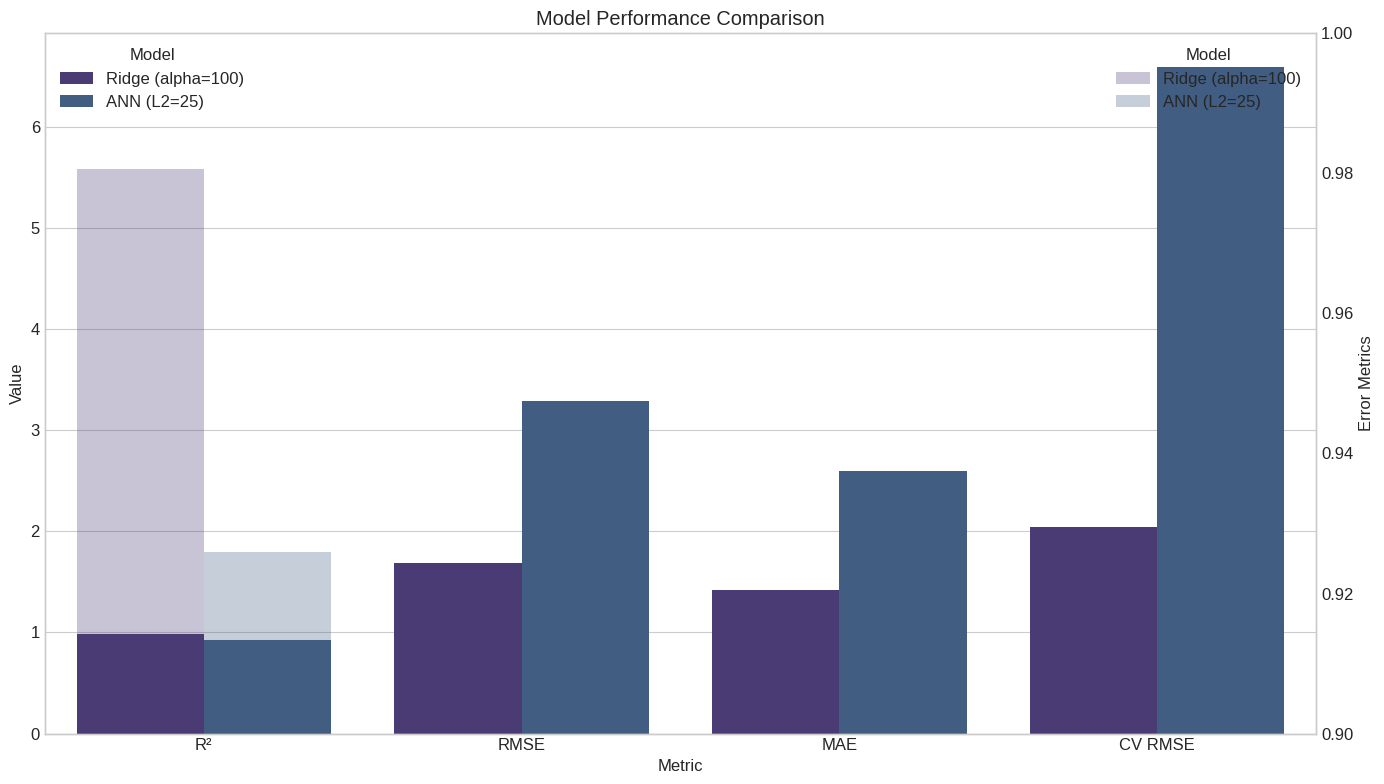

In [8]:
#Performance Comparison Plot
metrics = ['R²', 'RMSE', 'MAE', 'CV RMSE']
ridge_metrics = [0.9806, 1.6848, 1.4146, 2.0436]
ann_metrics = [0.9260, 3.2880, 2.5929, 6.5916]

metrics_df = pd.DataFrame({
    'Metric': metrics * 2,
    'Value': ridge_metrics + ann_metrics,
    'Model': ['Ridge (alpha=100)'] * 4 + ['ANN (L2=25)'] * 4
})

plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(x='Metric', y='Value', hue='Model', data=metrics_df)

if 'R²' in metrics:
    ax2 = plt.twinx()
    r2_data = metrics_df[metrics_df['Metric'] == 'R²'].copy()
    sns.barplot(x='Metric', y='Value', hue='Model', data=r2_data, ax=ax2, alpha=0.3)
    ax2.set_ylim(0.9, 1.0)
    ax2.set_ylabel('R² Value')
    ax2.grid(False)

plt.title('Model Performance Comparison')
plt.ylabel('Error Metrics')
plt.legend(title='Model')
plt.tight_layout()
plt.savefig('/content/model_performance_comparison.png')
plt.show()
plt.close()


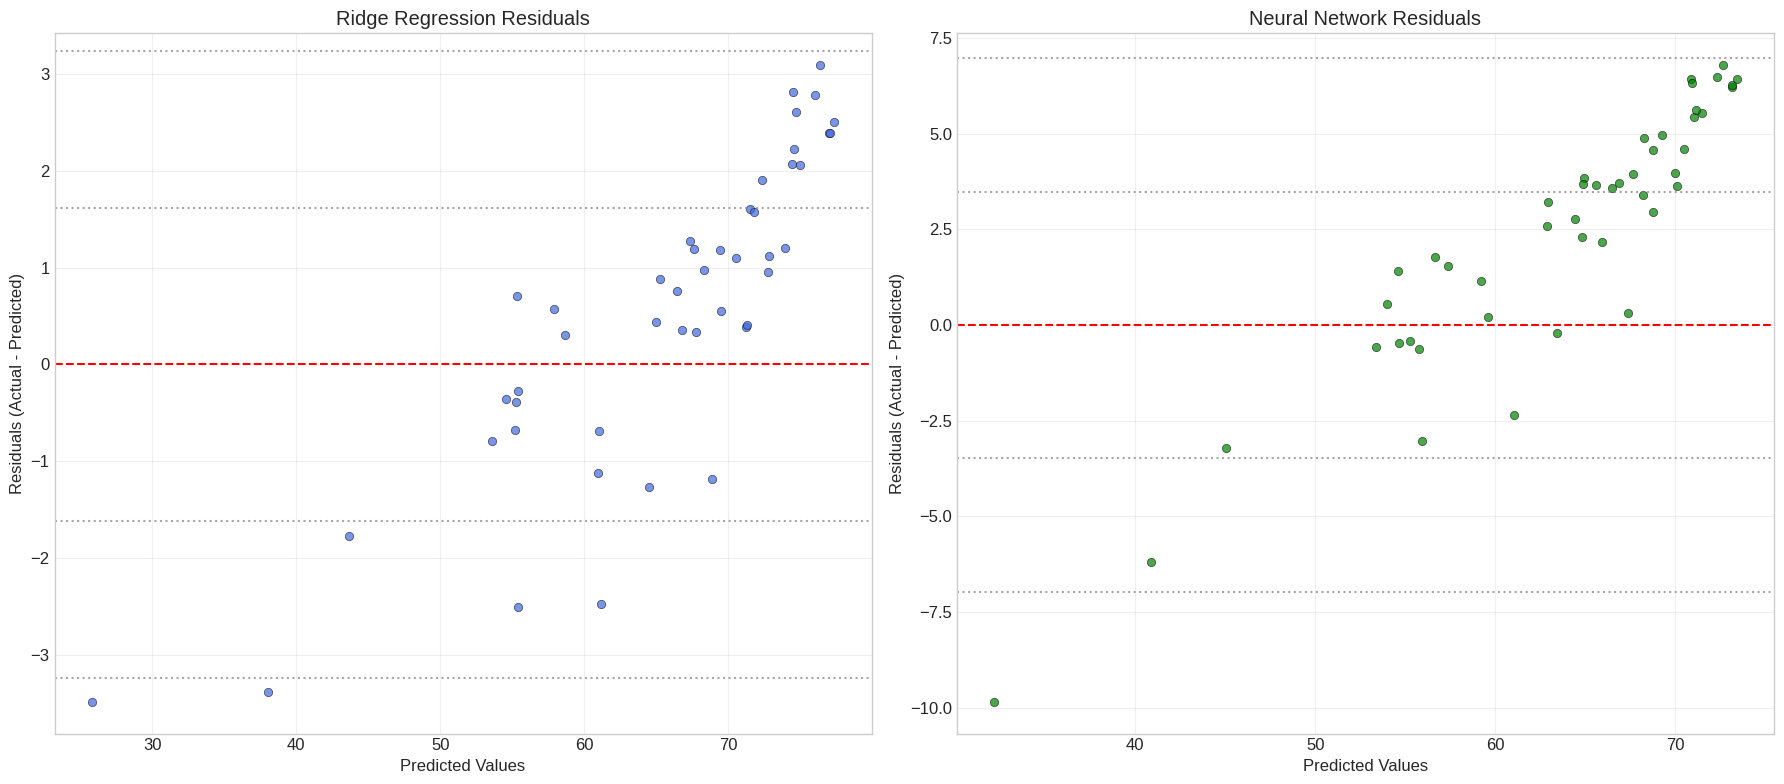

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Ridge model residuals
sns.scatterplot(x=ridge_pred, y=y_test-ridge_pred, alpha=0.7, edgecolor='k', color='royalblue', ax=ax1)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_title('Ridge Regression Residuals')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Residuals (Actual - Predicted)')
ax1.grid(True, alpha=0.3)

ridge_residuals_std = (y_test-ridge_pred).std()
ax1.axhline(y=ridge_residuals_std, color='gray', linestyle=':', alpha=0.7)
ax1.axhline(y=-ridge_residuals_std, color='gray', linestyle=':', alpha=0.7)
ax1.axhline(y=2*ridge_residuals_std, color='gray', linestyle=':', alpha=0.7)
ax1.axhline(y=-2*ridge_residuals_std, color='gray', linestyle=':', alpha=0.7)

# ANN model residuals
sns.scatterplot(x=ann_pred, y=y_test-ann_pred, alpha=0.7, edgecolor='k', color='green', ax=ax2)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_title('Neural Network Residuals')
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Residuals (Actual - Predicted)')
ax2.grid(True, alpha=0.3)

ann_residuals_std = (y_test-ann_pred).std()
ax2.axhline(y=ann_residuals_std, color='gray', linestyle=':', alpha=0.7)
ax2.axhline(y=-ann_residuals_std, color='gray', linestyle=':', alpha=0.7)
ax2.axhline(y=2*ann_residuals_std, color='gray', linestyle=':', alpha=0.7)
ax2.axhline(y=-2*ann_residuals_std, color='gray', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.savefig('/content/residual_plots.png')
plt.show()
plt.close()

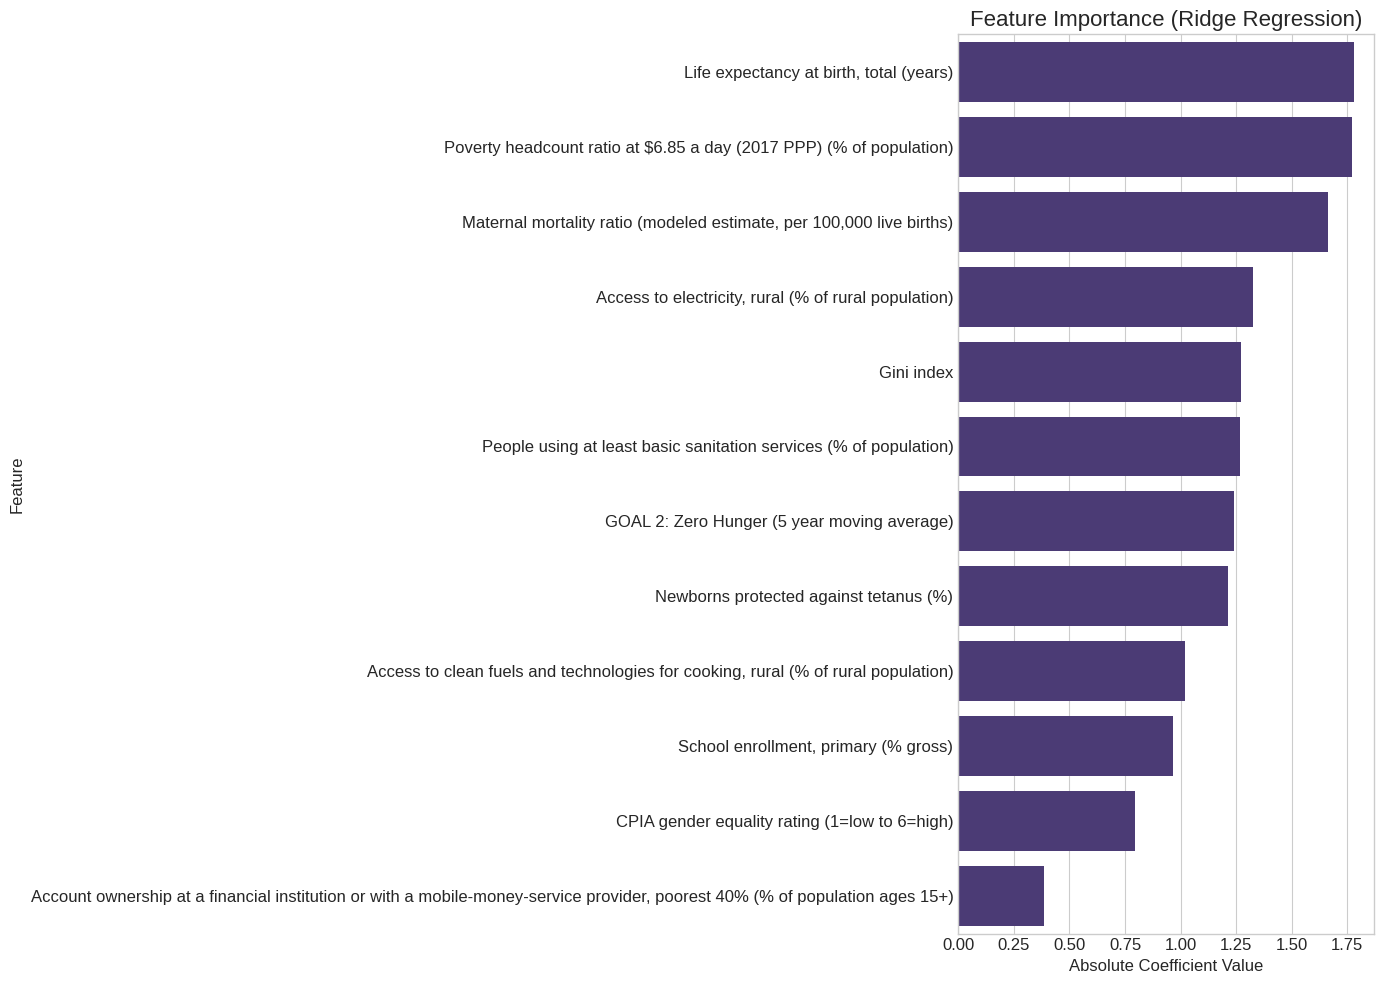

In [10]:
# Feature Importance
# For Ridge model
feature_names = X.columns
ridge_coefs = np.abs(ridge_model.coef_)

ridge_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': ridge_coefs
})
ridge_importance = ridge_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=ridge_importance)
plt.title('Feature Importance (Ridge Regression)', fontsize=16)
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.savefig('/content/ridge_feature_importance.png')
plt.show()
plt.close()

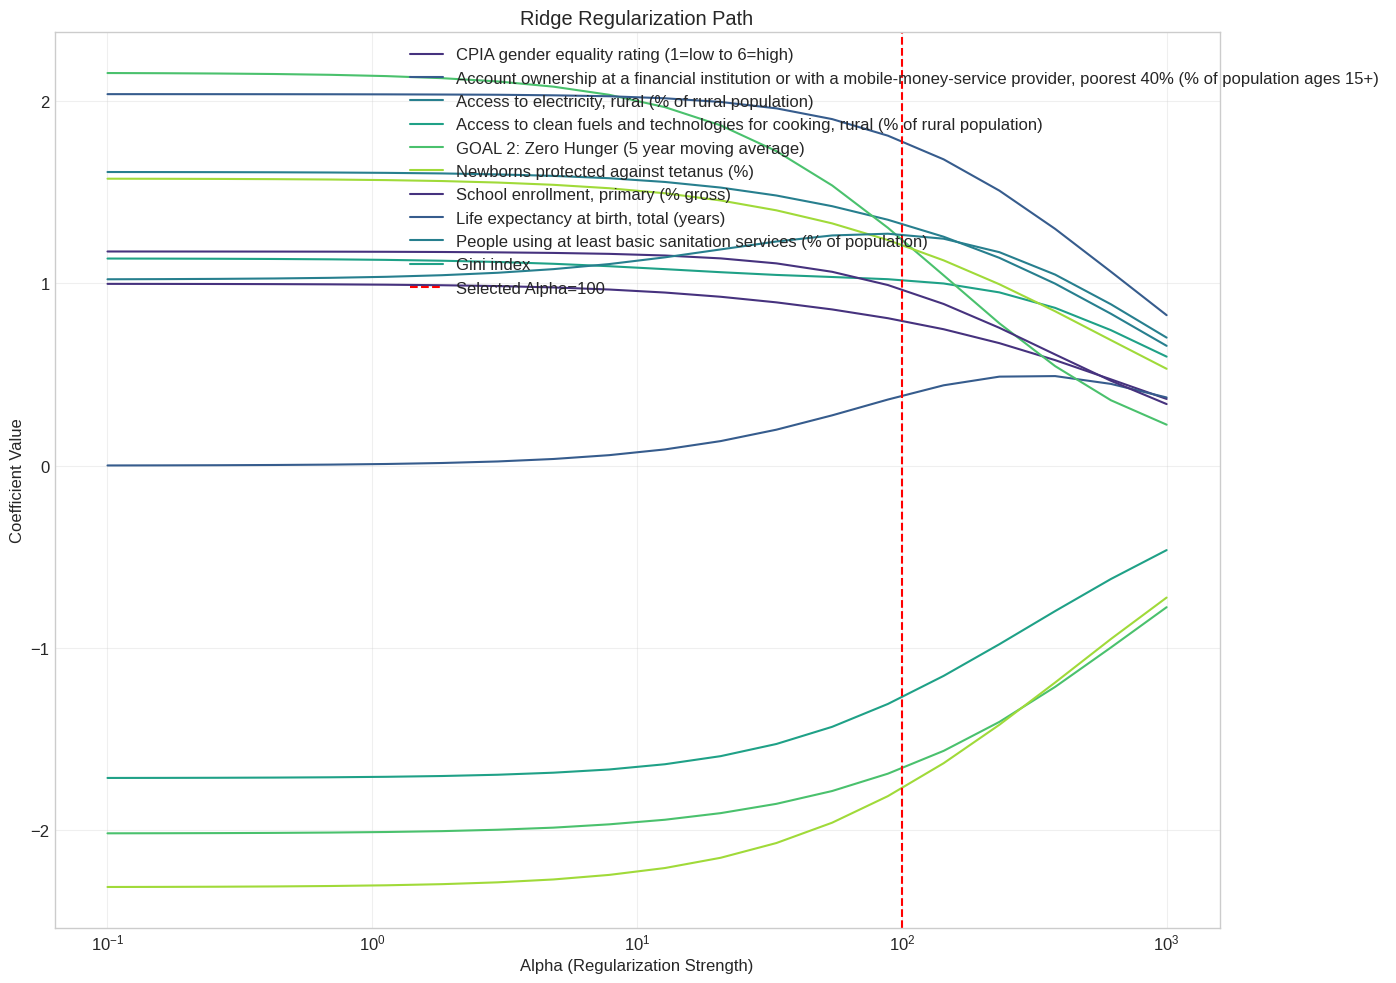

In [11]:
alphas = np.logspace(-1, 3, 20)
# Train Ridge models for different alphas and store coefficients
coefs = []
ridge_models = []
coefs = np.zeros((len(alphas), X.shape[1]))

# Fit Ridge models with different alphas
for i, alpha in enumerate(alphas):
    temp_ridge = Ridge(alpha=alpha, solver='lsqr')
    temp_ridge.fit(X_train_scaled, y_train)
    coefs[i, :] = temp_ridge.coef_

# Plot regularization path
plt.figure(figsize=(14, 10))
for i, feature in enumerate(feature_names):
    plt.plot(alphas, coefs[:, i], label=feature if i < 10 else '_nolegend_')  # Only show legend for top 10 features

plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Coefficient Value')
plt.title('Ridge Regularization Path')
plt.axvline(x=100, color='r', linestyle='--', label='Selected Alpha=100')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/ridge_regularization_path.png')
plt.show()
plt.close()